In [1]:
# We follow the guide available at 
# https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [2]:
import os
import requests
import zipfile
from pathlib import Path

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.utils as vutils

import random
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
pwd()

'/home/mb/MEGAsync/academic_work/projects/geometric_model_polycrystals/code/PyAPD/notebooks/extensions/summer_school'

In [5]:
# pyapd example

In [6]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "apd_data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
# else:
#     print(f"Did not find {image_path} directory, creating one...")
#     image_path.mkdir(parents=True, exist_ok=True)
    
#     # Download pizza, steak, sushi data
#     with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
#         request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
#         print("Downloading pizza, steak, sushi data...")
#         f.write(request.content)

#     # Unzip pizza, steak, sushi data
#     with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
#         print("Unzipping pizza, steak, sushi data...") 
#         zip_ref.extractall(image_path)

data/apd_data directory exists.


In [7]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
walk_through_dir(image_path)

There are 1 directories and 0 images in 'data/apd_data'.
There are 1 directories and 0 images in 'data/apd_data/train'.
There are 0 directories and 5000 images in 'data/apd_data/train/mono_disperse_small'.


In [9]:
# Setup train and testing paths
train_dir = image_path / "train"
#test_dir = image_path / "test"

train_dir#, test_dir

PosixPath('data/apd_data/train')

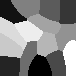

In [10]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)
img

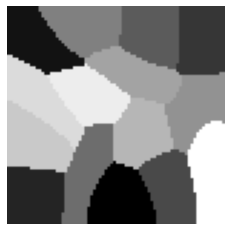

In [11]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
#plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
#plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [12]:
# Write transform for image
data_transform = transforms.Compose([
    # make sure we work with grayscale
    transforms.Grayscale(num_output_channels=1),
    # Resize the images to 64x64
    #transforms.Resize(size=(100, 100)),
    # Flip the images randomly on the horizontal
    #transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.Normalize((0.5,), (0.5,))
])


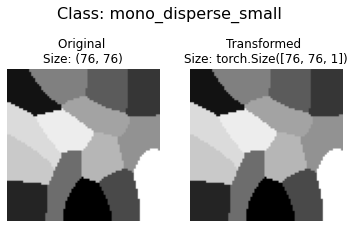

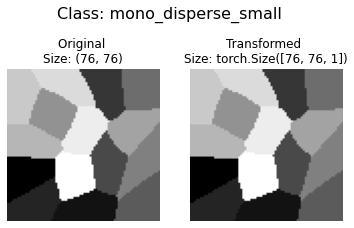

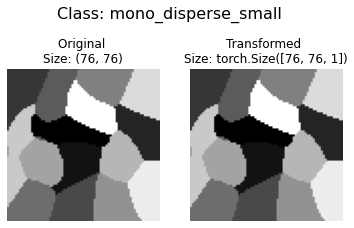

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image,cmap=plt.cm.gray) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [14]:
train_dir

PosixPath('data/apd_data/train')

In [15]:
dataset_pyapd = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

# Turn train and test Datasets into DataLoaders
dataloader_pyapd = DataLoader(dataset=dataset_pyapd, 
                              batch_size=64, # how many samples per batch?
                              #num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

In [16]:
# compare with FashionMNIST

dataset_fashion = torchvision.datasets.FashionMNIST(root='./FashionMNIST/', train = False,
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))
                                                     ]),
                       download=True)
dataloader_fashion = torch.utils.data.DataLoader(dataset_fashion, batch_size=64, shuffle=True)

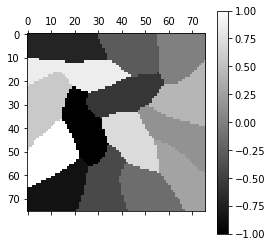

In [17]:
ix=14
x, _ = dataset_pyapd[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

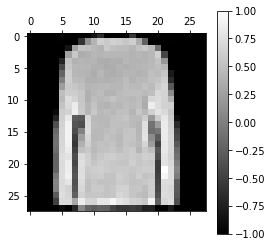

In [18]:
ix=149
x, _ = dataset_fashion[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

In [19]:
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())
    plt.axis(False)

In [20]:
# How you can get a batch of images from the dataloader:
xbatch, _ = next(iter(dataloader_fashion)) # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch.shape

torch.Size([64, 1, 28, 28])

In [21]:
28**2

784

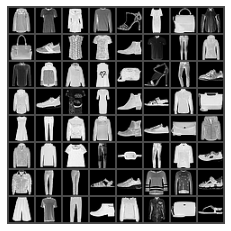

In [22]:
show_imgs(xbatch)

In [23]:
# How you can get a batch of images from the dataloader:
xbatch, _ = next(iter(dataloader_pyapd)) # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch.shape

torch.Size([64, 1, 76, 76])

In [24]:
76**2

5776

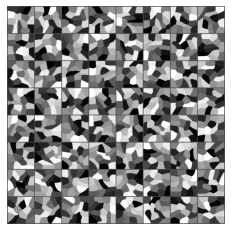

In [25]:
show_imgs(xbatch)

In [26]:
len(dataset_fashion)

10000

In [27]:
len(dataset_pyapd)

5000

In [28]:
784/128

6.125

In [29]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out